In [3]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors


%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import itertools
import random
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
import matplotlib.patches as patches

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from scipy.fftpack import fft,fftshift,ifft

In [4]:
n_clusters = 2000
labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/cluster_labels.npy'
cluster_model_labels = np.load(labels_file)

In [5]:
main_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201221_neural_weighted_behavior/"

response_files = [os.path.join(main_path, file) for file in os.listdir(main_path) if 'responses' in file]
bbb.sort_nicely(response_files)

responses = []
for file in response_files:
    responses.append(np.load(file))
responses = np.asarray(responses)

responses_split = np.reshape(responses, (49,2000,3,500))
responses_fft = fft(responses_split,axis=-1)
responses_fft[:,:,:,15:23] = 0
responses_fft[:,:,:,475:485] = 0
responses_filtered = ifft(responses_fft,axis=-1)
responses_filtered.shape

cluster_id = np.argmax(np.sum(responses_filtered[20,:,0,:].real, axis=1))

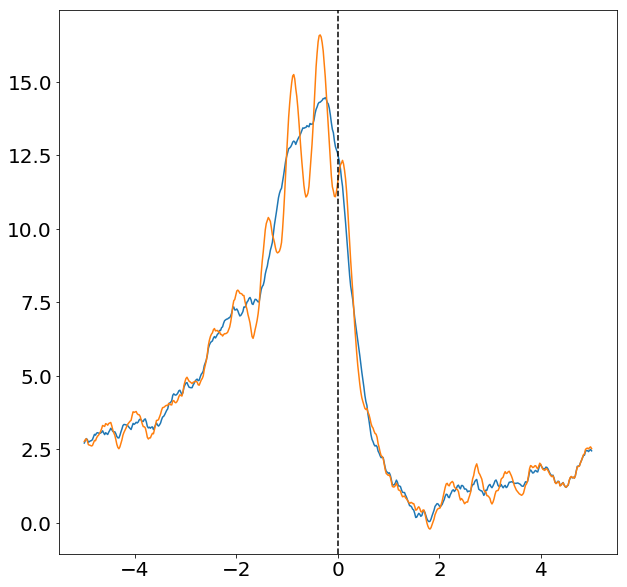

In [4]:
plt.figure(figsize=(10,10))
plt.plot(np.linspace(-5,5,500), responses_filtered[20,cluster_id,0,:])
plt.plot(np.linspace(-5,5,500), responses[20,cluster_id,:500])
plt.axvline(0,color='k',linestyle='--')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

In [6]:
responses_filtered = np.reshape(responses_filtered,(49,2000,1500))

all_z = []
for z in range(49):
    colored_by_betas = np.zeros((256*128,1500))
    for cluster_num in range(n_clusters):
        cluster_indicies = np.where(cluster_model_labels[z,:]==cluster_num)[0]
        colored_by_betas[cluster_indicies,:] = responses_filtered[z,cluster_num,:]
    colored_by_betas = colored_by_betas.reshape(256,128,1500)
    all_z.append(colored_by_betas)
all_z = np.asarray(all_z)

all_z = np.swapaxes(all_z,1,2)
all_z.shape

(49, 128, 256, 1500)

In [32]:
peak_max = np.max(all_z[:,:,:,0:500],axis=-1)
peak_time = np.argmax(all_z[:,:,:,0:500],axis=-1)
peak_time[np.where(peak_max<6)] = 0

In [31]:
start = 265
end = 220
middle = 250

# sample the colormaps that you want to use. Use 128 from each so we get 256
# colors in total
colors1 = plt.cm.Blues_r(np.linspace(0., 1, middle-end))
colors2 = plt.cm.Reds(np.linspace(0, 1, start-middle))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

#mymap.set_bad(color='black')



In [47]:
peak_time = np.ndarray.astype(peak_time,'float')
peak_time[np.where(peak_time==0)] = np.nan

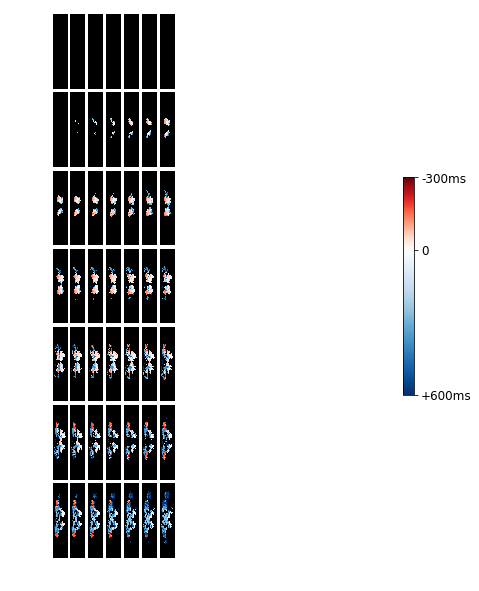

In [29]:
fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(7, 7), axes_pad=.05)
for i in range(49):
    cax = grid[i].imshow(peak_time[i,:,:],cmap=mymap,vmin=end,vmax=start);
    grid[i].axis('off')

cbar = fig.colorbar(cax, ticks=[start, middle, end],shrink=.4, anchor=(1.3,.5))
cbar.ax.set_yticklabels(['-300ms', '0', '+600ms'], fontsize=12)
    
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')#

In [48]:
peak_time = np.moveaxis(peak_time,0,2)

In [49]:
peak_time.shape

(128, 256, 49)

In [50]:
peak_time_iso = ants.resample_image(ants.from_numpy(peak_time),(int(512*0.65), int(1024*0.65), int(256*1)),1,1,).numpy()

In [23]:
peak_time_iso.shape

(332, 665, 256)

In [24]:
file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/luke.nii'
anatomy = np.asarray(nib.load(file).get_data(), dtype='float32')/1
anatomy = np.moveaxis(anatomy,0,1)
anatomy.shape

(512, 1024, 256)

In [25]:
anatomy_iso = ants.resample_image(ants.from_numpy(anatomy),(int(512*0.65), int(1024*0.65), int(256*1)),1,0).numpy()

In [51]:
to_plot = peak_time_iso

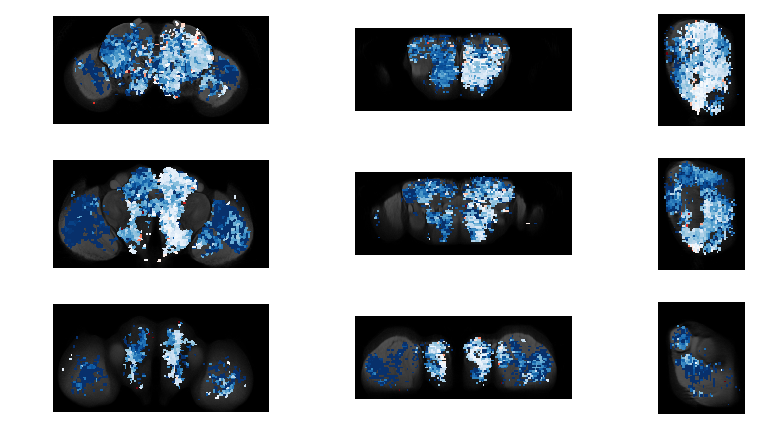

In [52]:
fig = plt.figure(figsize=(10,10))

#############
#### XY #####
#############
ax = fig.add_axes([0,.4,.3,.3])
z=70
ax.imshow(anatomy_iso[:,:,z],cmap='gray',vmax=3)
ax.imshow(to_plot[:,:,z],cmap=mymap,vmin=end,vmax=start)
ax.axis('off')

ax = fig.add_axes([0,.2,.3,.3])
z=140
ax.imshow(anatomy_iso[:,:,z],cmap='gray',vmax=3)
ax.imshow(to_plot[:,:,z],cmap=mymap,vmin=end,vmax=start)
ax.axis('off')

ax = fig.add_axes([0,0,.3,.3])
z=200
ax.imshow(anatomy_iso[:,:,z],cmap='gray',vmax=3)
ax.imshow(to_plot[:,:,z],cmap=mymap,vmin=end,vmax=start)
ax.axis('off')

#############
#### XZ #####
#############
ax = fig.add_axes([.42,.4,.3,.3])
x=70
ax.imshow(np.swapaxes(anatomy_iso[x,:,:],0,1),cmap='gray',vmax=3)
ax.imshow(np.swapaxes(to_plot[x,:,:],0,1),cmap=mymap,vmin=end,vmax=start)
ax.axis('off')

ax = fig.add_axes([.42,.2,.3,.3])
x=100
ax.imshow(np.swapaxes(anatomy_iso[x,:,:],0,1),cmap='gray',vmax=3)
ax.imshow(np.swapaxes(to_plot[x,:,:],0,1),cmap=mymap,vmin=end,vmax=start)
ax.axis('off')

ax = fig.add_axes([.42,0,.3,.3])
x=250
ax.imshow(np.swapaxes(anatomy_iso[x,:,:],0,1),cmap='gray',vmax=3)
ax.imshow(np.swapaxes(to_plot[x,:,:],0,1),cmap=mymap,vmin=end,vmax=start)
ax.axis('off')

#############
#### YZ #####
#############

ax = fig.add_axes([.84,.05,.12,.2])
y=160
ax.imshow(anatomy_iso[:,y,:],cmap='gray',vmax=3)
ax.imshow(to_plot[:,y,:],cmap=mymap,vmin=end,vmax=start)
ax.axis('off')

ax = fig.add_axes([.84,.25,.12,.2])
y=250
ax.imshow(anatomy_iso[:,y,:],cmap='gray',vmax=3)
ax.imshow(to_plot[:,y,:],cmap=mymap,vmin=end,vmax=start)
ax.axis('off')

ax = fig.add_axes([.84,.45,.12,.2])
y=360
ax.imshow(anatomy_iso[:,y,:],cmap='gray',vmax=3)
ax.imshow(to_plot[:,y,:],cmap=mymap,vmin=end,vmax=start)
ax.axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

# @Timepoint maps

In [ ]:
scipy.interpolate.interp1d(all_z,axis=-1)

In [7]:
all_z.shape

(49, 128, 256, 1500)

In [ ]:
diff = all_z[:,:,:,tp-2] - all_z[:,:,:,tp+2]
np.max(diff,axis=0)

In [ ]:
temp = np.where(map_XY_turn_all == map_XY_turn_pos)
map_XY_turn_all[temp] = map_XY_turn_all[temp]*-1

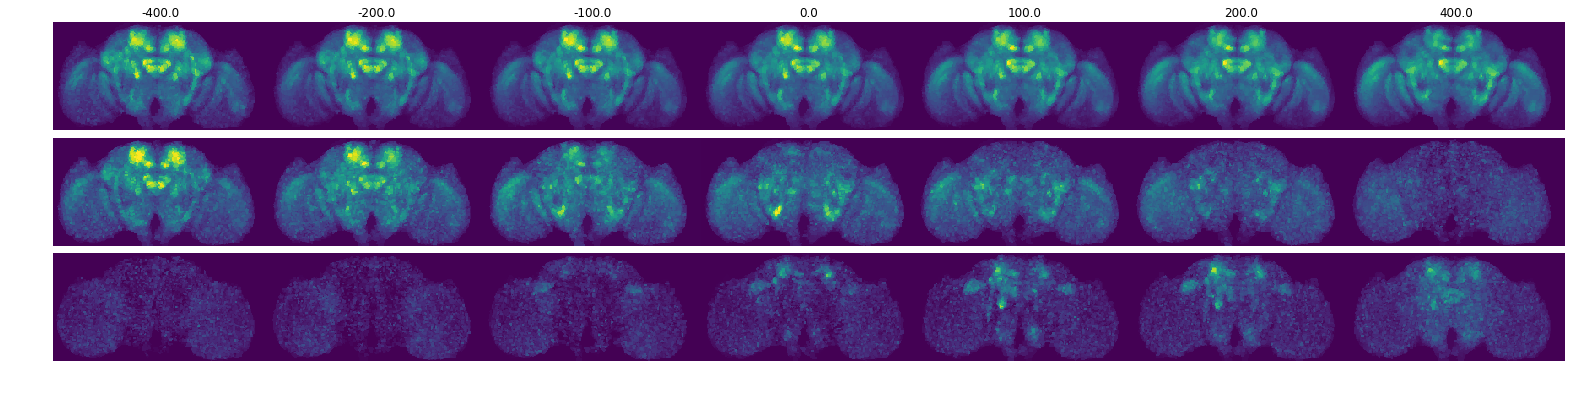

In [98]:
fig = plt.figure(figsize=(10,10))

a=np.linspace(5000,0,251)
b=np.linspace(-20,-5000,250)
realtimes = np.concatenate((a,b))
times = [270,260,255,250,245,240,230]

for i,tp in enumerate(times):
    ax = fig.add_axes([.3*i,.4,.3,.3])
    ax.imshow(np.max(all_z[:,:,:,tp],axis=0))
    ax.axis('off')
    ax.set_title(realtimes[tp],fontsize=12)
    
# future-past essentially derivative
for i,tp in enumerate(times):
    ax = fig.add_axes([.3*i,.24,.3,.3])
    # future-past, max, shows regions increasing
    diff = all_z[:,:,:,tp-2] - all_z[:,:,:,tp+2]
    ax.imshow(np.max(diff,axis=0),vmin=0,vmax=3)
    ax.axis('off')
    
for i,tp in enumerate(times):
    ax = fig.add_axes([.3*i,.08,.3,.3])
    # future-past, min, shows regions decreasing
    diff = all_z[:,:,:,tp-2] - all_z[:,:,:,tp+2]
    ax.imshow(np.min(diff,axis=0)*-1,vmin=0,vmax=3)
    ax.axis('off')

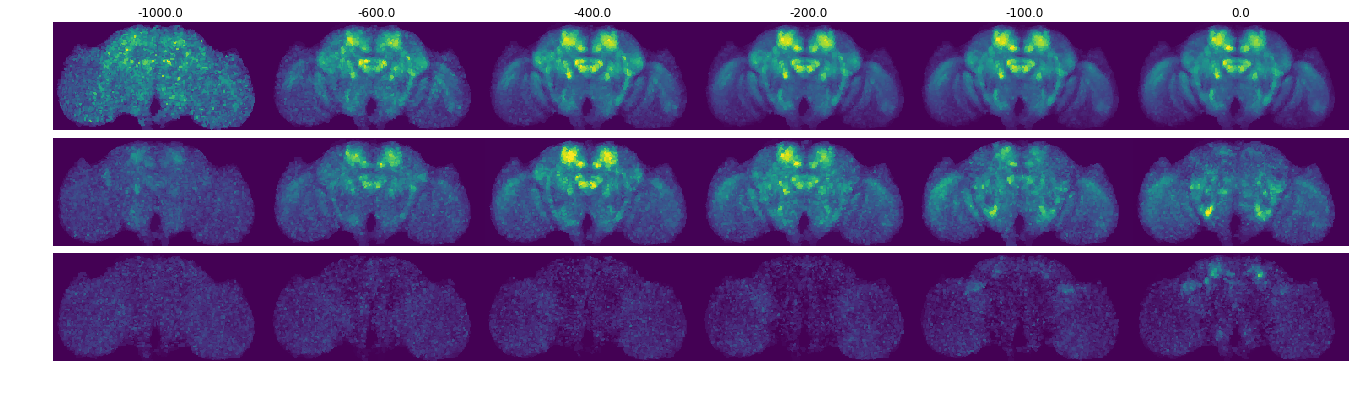

In [102]:
fig = plt.figure(figsize=(10,10))

a=np.linspace(5000,0,251)
b=np.linspace(-20,-5000,250)
realtimes = np.concatenate((a,b))
times = [300,280,270,260,255,250]

for i,tp in enumerate(times):
    ax = fig.add_axes([.3*i,.4,.3,.3])
    ax.imshow(np.max(all_z[:,:,:,tp],axis=0))
    ax.axis('off')
    ax.set_title(realtimes[tp],fontsize=12)
    
# future-past essentially derivative
for i,tp in enumerate(times):
    ax = fig.add_axes([.3*i,.24,.3,.3])
    # future-past, max, shows regions increasing
    diff = all_z[:,:,:,tp-2] - all_z[:,:,:,tp+2]
    ax.imshow(np.max(diff,axis=0),vmin=0,vmax=3)
    ax.axis('off')
    
for i,tp in enumerate(times):
    ax = fig.add_axes([.3*i,.08,.3,.3])
    # future-past, min, shows regions decreasing
    diff = all_z[:,:,:,tp-2] - all_z[:,:,:,tp+2]
    ax.imshow(np.min(diff,axis=0)*-1,vmin=0,vmax=3)
    ax.axis('off')

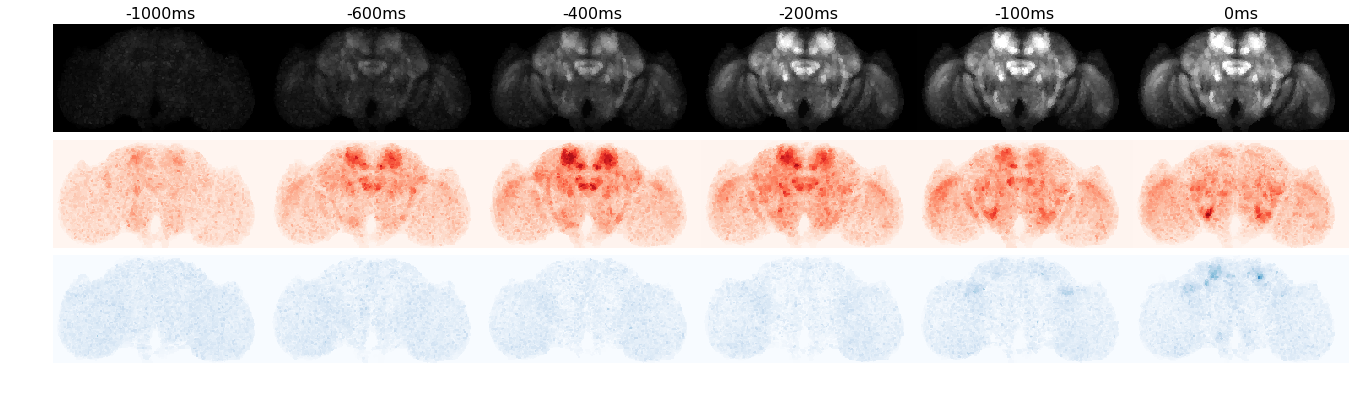

In [117]:
fig = plt.figure(figsize=(10,10))

a=np.linspace(5000,0,251)
b=np.linspace(-20,-5000,250)
realtimes = np.concatenate((a,b))
times = [300,280,270,260,255,250]

for i,tp in enumerate(times):
    ax = fig.add_axes([.3*i,.4,.3,.3])
    ax.imshow(np.max(all_z[:,:,:,tp],axis=0),vmin=0,vmax=20,cmap='gray')
    ax.axis('off')
    ax.set_title(str(int(realtimes[tp]))+'ms',fontsize=16)
    
# future-past essentially derivative
for i,tp in enumerate(times):
    ax = fig.add_axes([.3*i,.24,.3,.3])
    # future-past, max, shows regions increasing
    diff = all_z[:,:,:,tp-1] - all_z[:,:,:,tp+1]
    ax.imshow(np.max(diff,axis=0),vmin=0,vmax=2,cmap='Reds')
    ax.axis('off')
    
for i,tp in enumerate(times):
    ax = fig.add_axes([.3*i,.08,.3,.3])
    # future-past, min, shows regions decreasing
    diff = all_z[:,:,:,tp-1] - all_z[:,:,:,tp+1]
    ax.imshow(np.min(diff,axis=0)*-1,vmin=0,vmax=2,cmap='Blues')
    ax.axis('off')
    
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

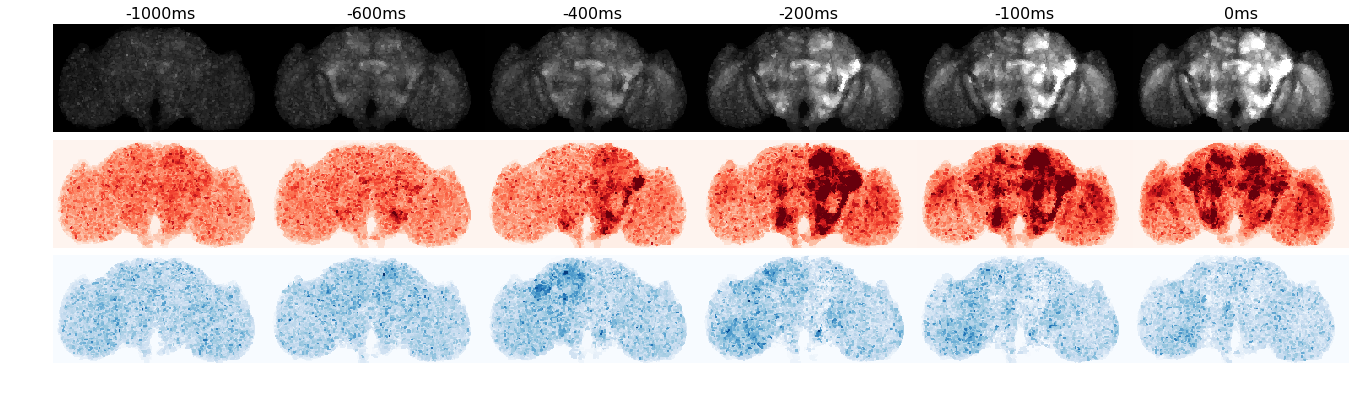

In [137]:
fig = plt.figure(figsize=(10,10))

a=np.linspace(5000,0,251)
b=np.linspace(-20,-5000,250)
realtimes = np.concatenate((a,b))
times = [300,280,270,260,255,250]
b = 1000 #either 0,500,or 1000

for i,tp in enumerate(times):
    ax = fig.add_axes([.3*i,.4,.3,.3])
    ax.imshow(np.max(all_z[:,:,:,tp+b],axis=0),vmin=0,vmax=20,cmap='gray')
    ax.axis('off')
    ax.set_title(str(int(realtimes[tp]))+'ms',fontsize=16)
    
# future-past essentially derivative
for i,tp in enumerate(times):
    ax = fig.add_axes([.3*i,.24,.3,.3])
    # future-past, max, shows regions increasing
    diff = all_z[:,:,:,tp+b-3] - all_z[:,:,:,tp+b+3]
    ax.imshow(np.max(diff,axis=0),vmin=0,vmax=4,cmap='Reds')
    ax.axis('off')
    
for i,tp in enumerate(times):
    ax = fig.add_axes([.3*i,.08,.3,.3])
    # future-past, min, shows regions decreasing
    diff = all_z[:,:,:,tp+b-3] - all_z[:,:,:,tp+b+3]
    ax.imshow(np.min(diff,axis=0)*-1,vmin=0,vmax=4,cmap='Blues')
    ax.axis('off')
    
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

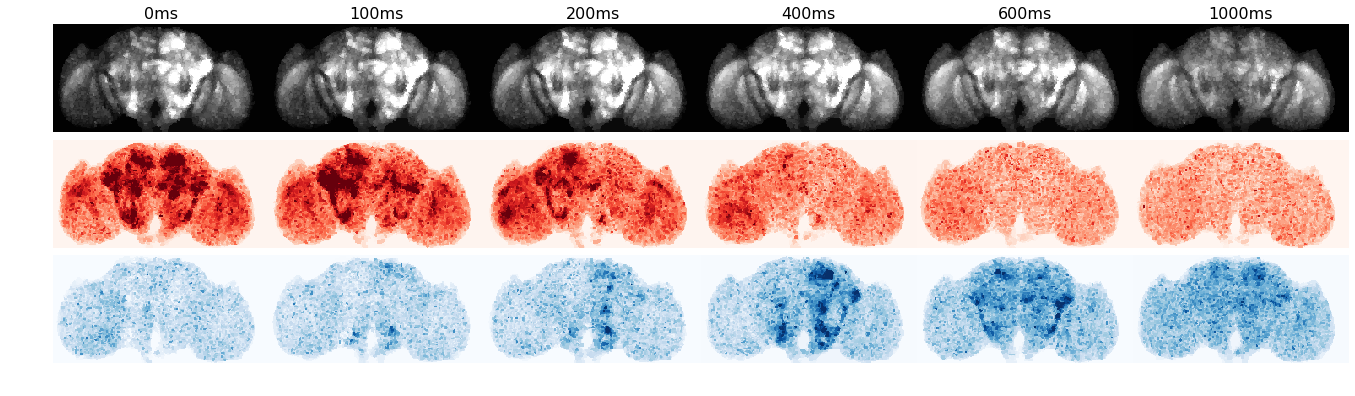

In [138]:
fig = plt.figure(figsize=(10,10))

a=np.linspace(5000,0,251)
b=np.linspace(-20,-5000,250)
realtimes = np.concatenate((a,b))
#times = [300,280,270,260,255,250]
times = [250,245,240,230,220,200]
b = 1000 #either 0,500,or 1000

for i,tp in enumerate(times):
    ax = fig.add_axes([.3*i,.4,.3,.3])
    ax.imshow(np.max(all_z[:,:,:,tp+b],axis=0),vmin=0,vmax=20,cmap='gray')
    ax.axis('off')
    ax.set_title(str(int(realtimes[tp]))+'ms',fontsize=16)
    
# future-past essentially derivative
for i,tp in enumerate(times):
    ax = fig.add_axes([.3*i,.24,.3,.3])
    # future-past, max, shows regions increasing
    diff = all_z[:,:,:,tp+b-3] - all_z[:,:,:,tp+b+3]
    ax.imshow(np.max(diff,axis=0),vmin=0,vmax=4,cmap='Reds')
    ax.axis('off')
    
for i,tp in enumerate(times):
    ax = fig.add_axes([.3*i,.08,.3,.3])
    # future-past, min, shows regions decreasing
    diff = all_z[:,:,:,tp+b-3] - all_z[:,:,:,tp+b+3]
    ax.imshow(np.min(diff,axis=0)*-1,vmin=0,vmax=4,cmap='Blues')
    ax.axis('off')
    
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

In [36]:
len(realtimes)

500

In [19]:
realtimes[tp]

-991.9839679358715

In [29]:
peak_time.shape

(49, 128, 256)

(100, 300)

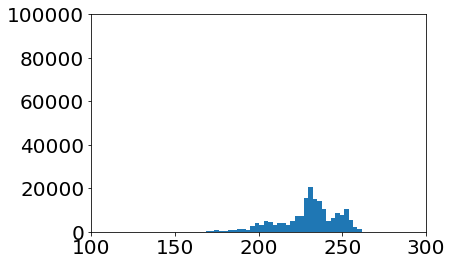

In [35]:
plt.hist(peak_time.ravel(),bins=100);
plt.ylim(0,100000)
plt.xlim(100,300)